<a href="https://colab.research.google.com/github/Lexaun-chen/STAT-4830-Group-Project/blob/main/GPU_MNL_with_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/MyDrive/STAT4830 Group Project/Week4

/content/drive/MyDrive/STAT4830 Group Project/Week4


In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available:", device)
    torch.cuda.init()
else:
    device = torch.device("cpu")
    print("GPU unavailable: CPU")

GPU available: cuda


In [27]:
class Sales:
    def __init__(self, all_offer_sets, sell_num, mask):
        self.offer_set_list = []
        self.fw = None
        self.N_sales = torch.tensor(np.concatenate(sell_num, axis=1), dtype=torch.float64, device=device)
        self.offer_feature = torch.tensor(all_offer_sets, dtype=torch.float64)
        self.original_shape = self.offer_feature.shape
        self.feature_concat = self.offer_feature.reshape(-1, self.offer_feature.shape[2]).to(device)
        self.N = len(all_offer_sets)
        self.mask = torch.tensor(mask, dtype=torch.float64, device=device)
        self.mask_flat = self.mask.reshape((-1,))
        self.masked_feature_concat = self.feature_concat[self.mask_flat == 1]

    def calculate_all_choice_prob(self, W):
        assert W is not None, "Weight matrix W is None. Ensure W is initialized correctly."
        rule_feature = self.feature_concat
        self.fw = self.calculate_choice_prob(rule_feature, W)
        return self.fw

    def calculate_choice_prob(self, rule_feature, W):
        Z = torch.matmul(rule_feature, W).reshape(self.original_shape[:2])
        masked_Z = Z.masked_fill(self.mask == 0, float('-inf'))
        softmax_result = F.softmax(masked_Z, dim=-1).reshape((-1, 1))[self.mask_flat == 1]  #convert utility to prob
        return softmax_result  # A column vector containing only the selection probabilities of valid options

In [28]:
class Problem_MNL:
    def __init__(self, S, N, M): #Option set, Number of sales, Mask
        self.W = None
        self.sales = Sales(S, N, M)
        # Define and initialize the ruleset
        self.feature_num = S.shape[-1]
        # Put the feature to the GPU
        self.sales.feature_concat = self.sales.feature_concat.to(device)
        # Define a consumer list that contain consumer types
        self.consumer_list = []
        # Define the main problem NLL loss
        self.NLL_main = None
        # Define the current likelihood convex combination
        self.g = None
        # Define the current likelihood gradient for support finding
        self.NLL_gradient = None
        # Define a list to contain all fw choice likelihood
        self.fw_list = []
        # Define a new sales data for further estimation
        self.sales_estimate = None

    def loss(self, W):
        N = self.sales.N
        N_sales = self.sales.N_sales
        normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
        fw = self.sales.calculate_all_choice_prob(W)
        fw_log = torch.log(fw)
        return -normalize_term * torch.matmul(N_sales, fw_log)

    def estimate(self, S, N, M):
        sales_estimate = Sales(S, N, M)
        N = sales_estimate.N
        N_sales = sales_estimate.N_sales
        normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
        fw = sales_estimate.calculate_all_choice_prob(self.W)
        fw_log = torch.log(fw)
        return -normalize_term * torch.matmul(N_sales, fw_log)

    def optimize_w(self, lr=5e-6, optimizer_type='Adam' ):
        W = torch.zeros(self.feature_num, 1, dtype=torch.float64, requires_grad=True, device=device ) #Set to be derivable
        loss_previous = 1e10000

        if optimizer_type == 'Adam':
            optimizer = optim.Adam([W], lr=lr)
        elif optimizer_type == 'SGD':
            optimizer = optim.SGD([W], lr=lr)
        else:
            raise ValueError("Unsupported optimizer type")

        NLL_list = []
        train_loss_list = []
        test_loss_list = []
        w_previous = None

        optimizer.zero_grad()
        epoches = 10000

        for epoch in range(epoches):
            LOSS = self.loss(W)
            LOSS.backward()
            optimizer.step()
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epoches}], Loss: {LOSS.item():.4f}')
            loss_current = LOSS.item()
            if loss_current < loss_previous:
                loss_previous = loss_current
                with torch.no_grad():
                    # w_previous = W
                    w_previous = W.clone().detach().requires_grad_(True)
                    self.W = W
            else:
              if w_previous is not None:
                  W = w_previous.clone().detach().requires_grad_(True)
              else:
                  print("Early stopping triggered without a valid previous weight.")

              break

            NLL_list.append(loss_current)

            test_loss = self.estimate(te_offerset_list, te_sell_list, te_mask_list)
            test_loss_list.append(test_loss.item())

        self.W = W

        return NLL_list, test_loss_list


In [30]:
def get_offer_data(data_para):
    offerset_list = []
    sell_list = []
    mask_list = []
    max_num = 32
    for srch_id, group in data_para:
        num_product = len(group)
        offerset = group.drop(columns=['booking_bool', 'srch_id']).values
        offer_dummy = np.zeros((max_num - num_product, offerset.shape[1]))
        offerset = np.vstack((offerset, offer_dummy)) #Padding Offer Sets
        offer_mask = np.append(np.ones(num_product), np.zeros(max_num - num_product)) # Mask for 0 from padding

        # if group['booking_bool'].sum() == 0: # No hotel reservations
        #     num_sell = np.append(group['booking_bool'].values, 1).reshape(1, -1) # Create and Select "not buy" option
        # else:
        #     num_sell = np.append(group['booking_bool'].values, 0).reshape(1, -1)

        num_sell = group['booking_bool'].values.reshape(1, -1)
        offerset_list.append(offerset)
        sell_list.append(num_sell)
        mask_list.append(offer_mask)

    offerset_list = np.array(offerset_list)
    mask_list = np.array(mask_list)

    return offerset_list, sell_list, mask_list


search_info = ['srch_id']
feature = ['position', 'prop_starrating',
           'prop_location_score1', 'prop_log_historical_price',
           'prop_brand_bool', 'promotion_flag', 'srch_booking_window', 'srch_length_of_stay',
           'srch_adults_count', 'srch_children_count', 'srch_room_count',
           'srch_saturday_night_bool', 'price_usd', 'random_bool', 'booking_bool']

tr_data = pd.read_csv('train_28-32_10000.csv')
te_data = pd.read_csv('test_28-32_1000.csv')
tr_data = tr_data[search_info + feature]
te_data = te_data[search_info + feature]
tr_offerset_list, tr_sell_list, tr_mask_list = get_offer_data(tr_data.groupby('srch_id'))
te_offerset_list, te_sell_list, te_mask_list = get_offer_data(te_data.groupby('srch_id'))

==================Training with learning rate 1e-05 and optimizer Adam=================== 
Epoch [100/10000], Loss: 3.3969
Epoch [200/10000], Loss: 3.3677
Epoch [300/10000], Loss: 3.3462
Epoch [400/10000], Loss: 3.3306
Epoch [500/10000], Loss: 3.3191
Epoch [600/10000], Loss: 3.3099
Epoch [700/10000], Loss: 3.3012
Epoch [800/10000], Loss: 3.2912
Epoch [900/10000], Loss: 3.2784
Epoch [1000/10000], Loss: 3.2620
Epoch [1100/10000], Loss: 3.2436
Epoch [1200/10000], Loss: 3.2263
Epoch [1300/10000], Loss: 3.2131
Epoch [1400/10000], Loss: 3.2049
Epoch [1500/10000], Loss: 3.2004
Epoch [1600/10000], Loss: 3.1965
Epoch [1700/10000], Loss: 3.1891
Epoch [1800/10000], Loss: 3.1761
Epoch [1900/10000], Loss: 3.1596
Epoch [2000/10000], Loss: 3.1446
Epoch [2100/10000], Loss: 3.1345
Epoch [2200/10000], Loss: 3.1291
Epoch [2300/10000], Loss: 3.1264
Epoch [2400/10000], Loss: 3.1238
Epoch [2500/10000], Loss: 3.1193
Epoch [2600/10000], Loss: 3.1112
Epoch [2700/10000], Loss: 3.0995
Epoch [2800/10000], Loss: 3

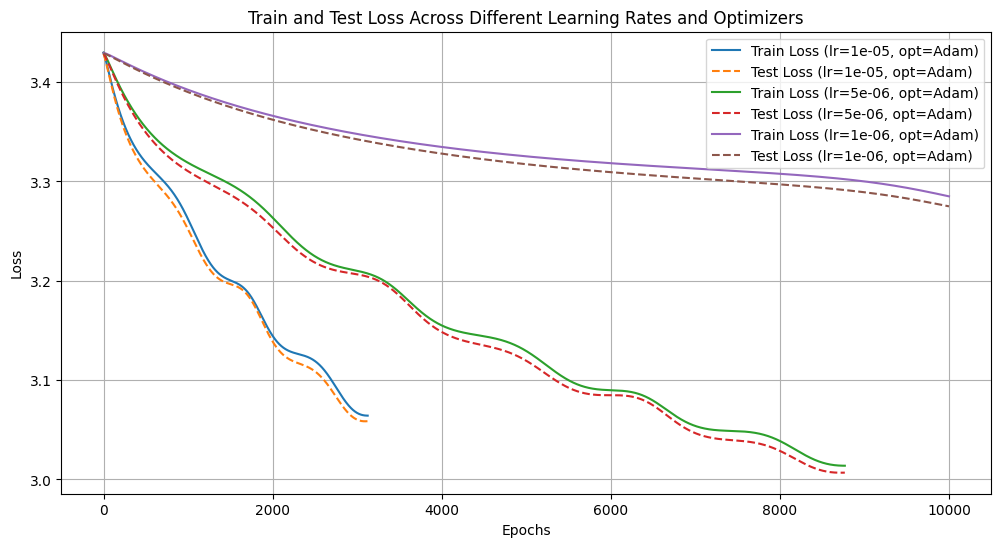

In [31]:
def train_MNL_LR(lr, optimizer_type):
    problem = Problem_MNL(tr_offerset_list, tr_sell_list, tr_mask_list)
    NLL_list, test_loss_list = problem.optimize_w(lr=lr, optimizer_type=optimizer_type)
    return problem, NLL_list,test_loss_list

learning_rates = [1e-5, 5e-6, 1e-6]
optimizers = ['Adam']

plt.figure(figsize=(12, 6))

for lr in learning_rates:
    for opt in optimizers:
        print(f"==================Training with learning rate {lr} and optimizer {opt}=================== ")
        MNL_problem, NLL_LIST, test_loss_list = train_MNL_LR(lr, opt)
        plt.plot(NLL_LIST, label=f'Train Loss (lr={lr}, opt={opt})')
        plt.plot(test_loss_list, linestyle='--', label=f'Test Loss (lr={lr}, opt={opt})')

plt.title('Train and Test Loss Across Different Learning Rates and Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


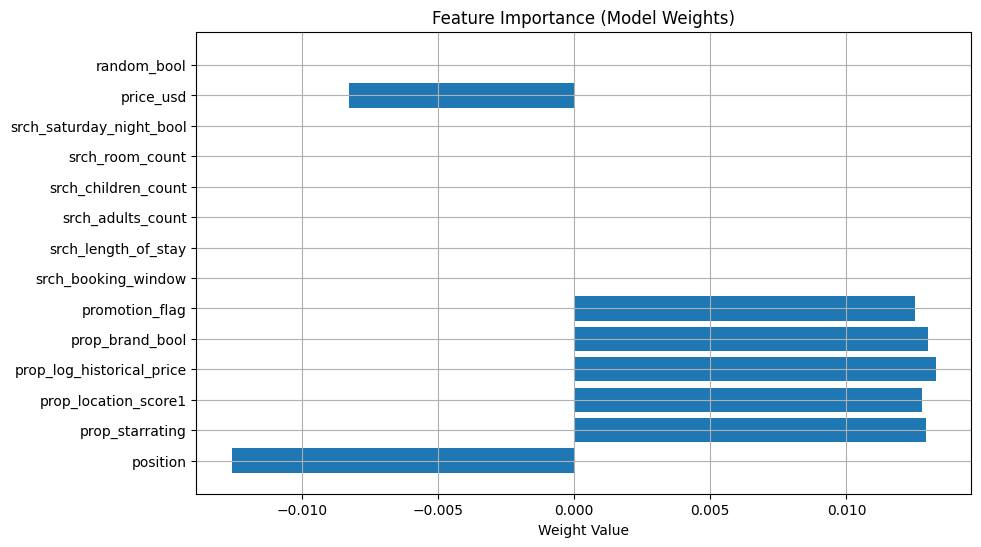

In [32]:
# Feature Weight
plt.figure(figsize=(10, 6))
plt.barh(feature[:-1], MNL_problem.W.cpu().detach().numpy().flatten())
plt.title('Feature Importance (Model Weights)')
plt.xlabel('Weight Value')
plt.grid(True)
plt.show()

Since the highly homogenous form in the loss plots of train and test dataset, we do some further exploration.

1.   Whether user information overlaps between the training data set and the test data set



In [33]:
tr_srch_ids = tr_data['srch_id'].unique()
te_srch_ids = te_data['srch_id'].unique()

# Find the overlapping srch_id values using numpy's intersect1d function
# This function returns the common elements in two arrays
overlapping_srch_ids = np.intersect1d(tr_srch_ids, te_srch_ids)

# Check if there are any overlapping srch_ids
# If the size of overlapping_srch_ids is greater than 0, it means there are overlaps
if overlapping_srch_ids.size > 0:
    print("There are overlapping srch_ids between tr_data and te_data.")
    print("The number of overlapping srch_ids is:", overlapping_srch_ids.size)
    print("The overlapping srch_ids are:", overlapping_srch_ids)
else:
    print("There are no overlapping srch_ids between tr_data and te_data.")

There are no overlapping srch_ids between tr_data and te_data.
